# Imports

In [1]:
import os
import shutil
from pathlib import Path
import numpy as np
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import kagglehub
import random

# Helpers

In [2]:
def open_tif(fn, cls=torch.Tensor):
    im = np.array(Image.open(fn)).astype('float32')
    return cls(im)

def map_filename(base_fn, str1, str2):
    return Path(str(base_fn).replace(str1, str2))

def get_filenames(red_filename):
    return [red_filename,
            map_filename(red_filename, 'red', 'green'),
            map_filename(red_filename, 'red', 'blue'),
            map_filename(red_filename, 'red', 'nir')]

def get_ground_truth(red_filename):
    return map_filename(red_filename, 'red', 'gt')

def open_ms_tif(files):
    ms_img = None
    for path in files:
        img = open_tif(path)
        if ms_img is None:
            ms_img = img[None]  # Add channel axis.
        else:
            ms_img = np.concatenate([ms_img, img[None]], axis=0)
    return torch.Tensor(ms_img)  # Shape: [4, height, width]

def is_all_zeros(fn):
    img = np.array(Image.open(fn)).astype('float32')
    return np.all(img == 0)

In [3]:
def normalize_band(band):
    band_min, band_max = band.min(), band.max()
    norm = (band - band_min) / (band_max - band_min) * 255.0
    return norm.astype(np.uint8)

def load_normalized_bands(red_file):
    band_files = get_filenames(red_file)
    ms_image = open_ms_tif(band_files)
    ms_np = ms_image.numpy()
    return {
        'red': normalize_band(ms_np[0]),
        'green': normalize_band(ms_np[1]),
        'blue': normalize_band(ms_np[2]),
        'nir': normalize_band(ms_np[3])
    }

def plot_bands(bands, band_names, figsize=(20, 5)):
    fig, axs = plt.subplots(1, len(bands), figsize=figsize)
    for i, band in enumerate(bands):
        axs[i].imshow(band, cmap='gray')
        axs[i].set_title(band_names[i])
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

def plot_composite_rgb(normalized):
    rgb = np.stack([normalized['red'], normalized['green'], normalized['blue']], axis=-1)
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb)
    plt.title("Normalized Composite RGB Image")
    plt.axis('off')
    plt.show()

def compute_otsu_masks(normalized, display_hist=True):
    band_names = ['Red', 'Green', 'Blue', 'NIR']
    masks = []
    thresholds = []

    if display_hist:
        plt.figure(figsize=(16, 8))

    for i, band in enumerate([normalized['red'], normalized['green'], normalized['blue'], normalized['nir']]):
        hist, bins = np.histogram(band.ravel(), bins=256, range=[0, 256])
        ret, mask = cv2.threshold(band, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholds.append(ret)
        masks.append(mask)

        if display_hist:
            plt.subplot(2, 2, i + 1)
            plt.plot(hist)
            plt.title(f"{band_names[i]} Histogram\n(Otsu Threshold = {ret:.0f})")
            plt.xlabel("Pixel Intensity")
            plt.ylabel("Frequency")

    if display_hist:
        plt.tight_layout()
        plt.show()

    return masks, thresholds

def combine_otsu_masks(otsu_masks, vote_threshold=3):
    binary_masks = np.stack([mask // 255 for mask in otsu_masks], axis=0)
    vote_sum = np.sum(binary_masks, axis=0)
    segmentation = np.where(vote_sum >= vote_threshold, 255, 0).astype(np.uint8)
    return segmentation

def compute_error_visualization(segmentation, ground_truth):
    false_positive = np.logical_and(segmentation == 255, ground_truth == 0)
    false_negative = np.logical_and(segmentation == 0, ground_truth == 255)
    error_vis = np.ones((*ground_truth.shape, 3), dtype=np.uint8) * 128
    error_vis[false_positive] = [255, 0, 0]
    error_vis[false_negative] = [0, 0, 255]
    return error_vis

def plot_segmentation_results(ground_truth, segmentation, error_vis, titles):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(ground_truth, cmap='gray')
    axs[0].set_title(titles[0])
    axs[0].axis('off')

    axs[1].imshow(segmentation, cmap='gray')
    axs[1].set_title(titles[1])
    axs[1].axis('off')

    axs[2].imshow(error_vis)
    axs[2].set_title(titles[2])
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# Set-up

In [4]:
dataset_path = kagglehub.dataset_download("sorour/38cloud-cloud-segmentation-in-satellite-images")

local_save_dir = "local_dataset"
os.makedirs(local_save_dir, exist_ok=True)
shutil.copytree(dataset_path, local_save_dir, dirs_exist_ok=True)

train_red_folder = os.path.join(local_save_dir, "38-Cloud_training", "train_red")
red_files = [os.path.join(train_red_folder, f) for f in os.listdir(train_red_folder) if f.endswith('.TIF')]
red_files = [f for f in red_files if not is_all_zeros(f)]
selected_red = red_files[404]



100%|██████████| 12.2G/12.2G [07:32<00:00, 28.8MB/s]

Extracting files...


# Data Exploration

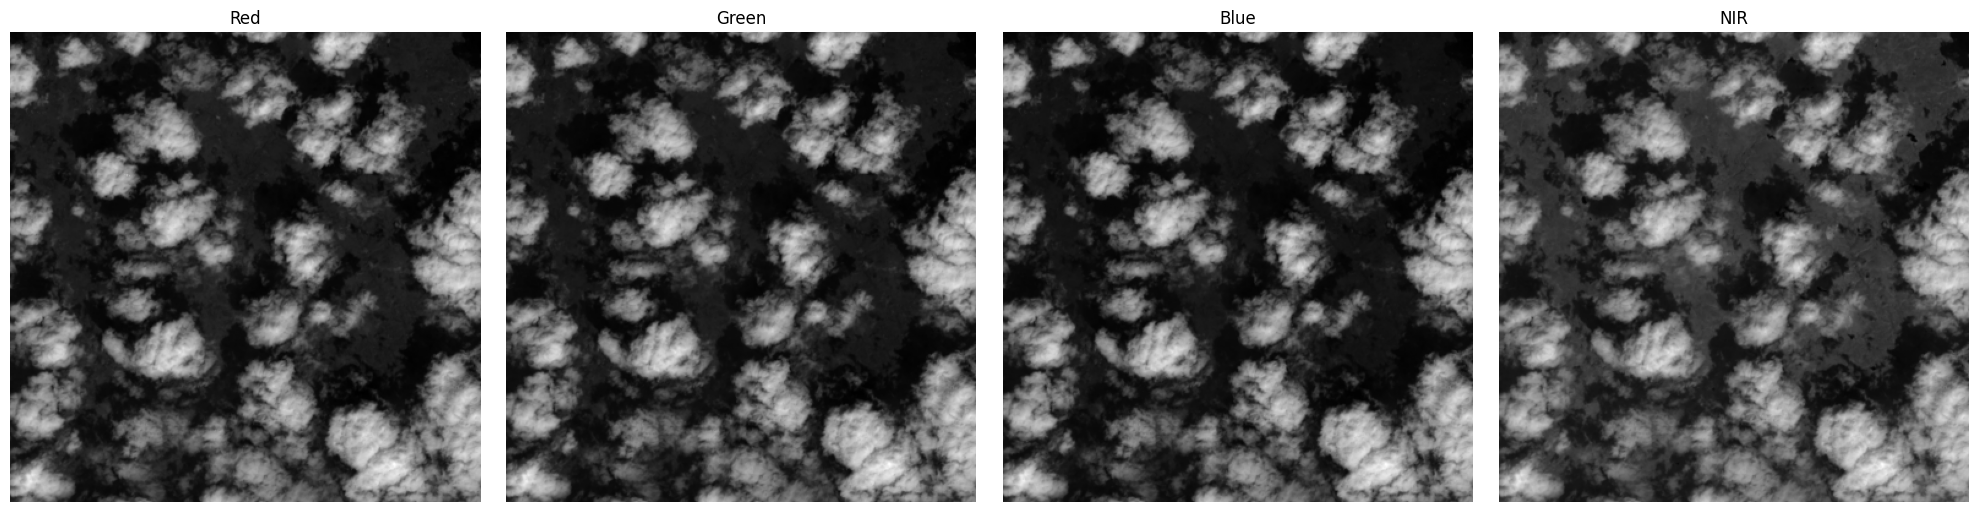

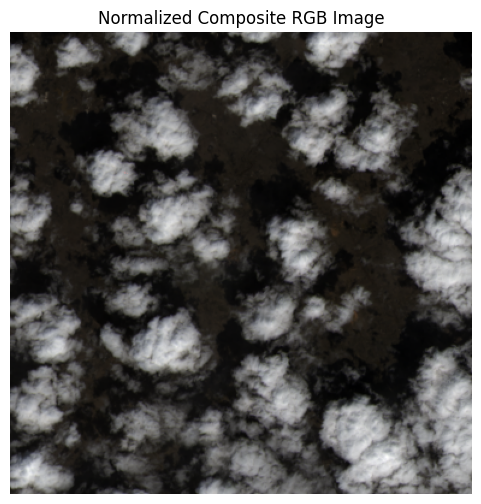

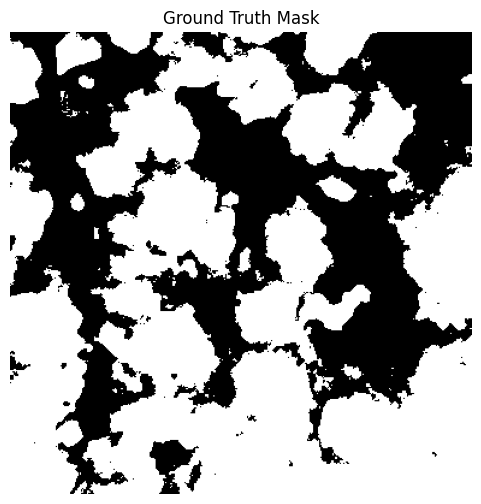

In [5]:
normalized = load_normalized_bands(selected_red)
plot_bands([normalized['red'], normalized['green'], normalized['blue'], normalized['nir']],
           ['Red', 'Green', 'Blue', 'NIR'])

plot_composite_rgb(normalized)

gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)
plt.figure(figsize=(6, 6))
plt.imshow(ground_truth, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')
plt.show()


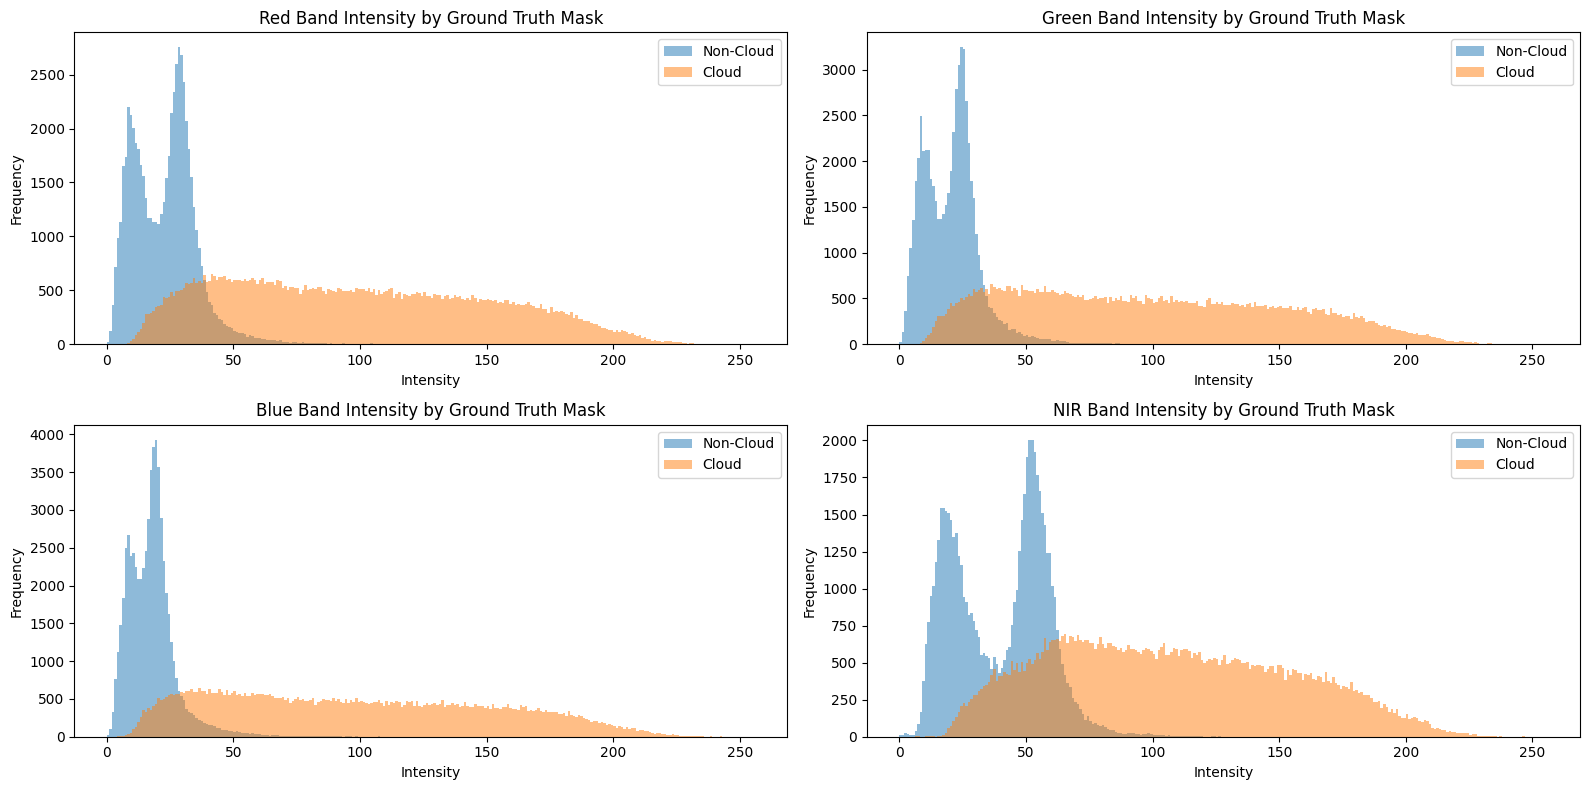

In [6]:
bands_norm = [normalized['red'], normalized['green'], normalized['blue'], normalized['nir']]
band_names = ['Red', 'Green', 'Blue', 'NIR']

# Plot histograms split by class (Cloud vs Non-Cloud).
gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)

plt.figure(figsize=(16, 8))
for i, (band, name) in enumerate(zip(bands_norm, band_names)):
    cloud_pixels = band[ground_truth == 255]
    noncloud_pixels = band[ground_truth == 0]

    plt.subplot(2, 2, i + 1)
    plt.hist(noncloud_pixels.flatten(), bins=256, range=(0, 256), alpha=0.5, label='Non-Cloud')
    plt.hist(cloud_pixels.flatten(), bins=256, range=(0, 256), alpha=0.5, label='Cloud')
    plt.title(f"{name} Band Intensity by Ground Truth Mask")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.legend()
plt.tight_layout()
plt.show()

# Otsu's Method

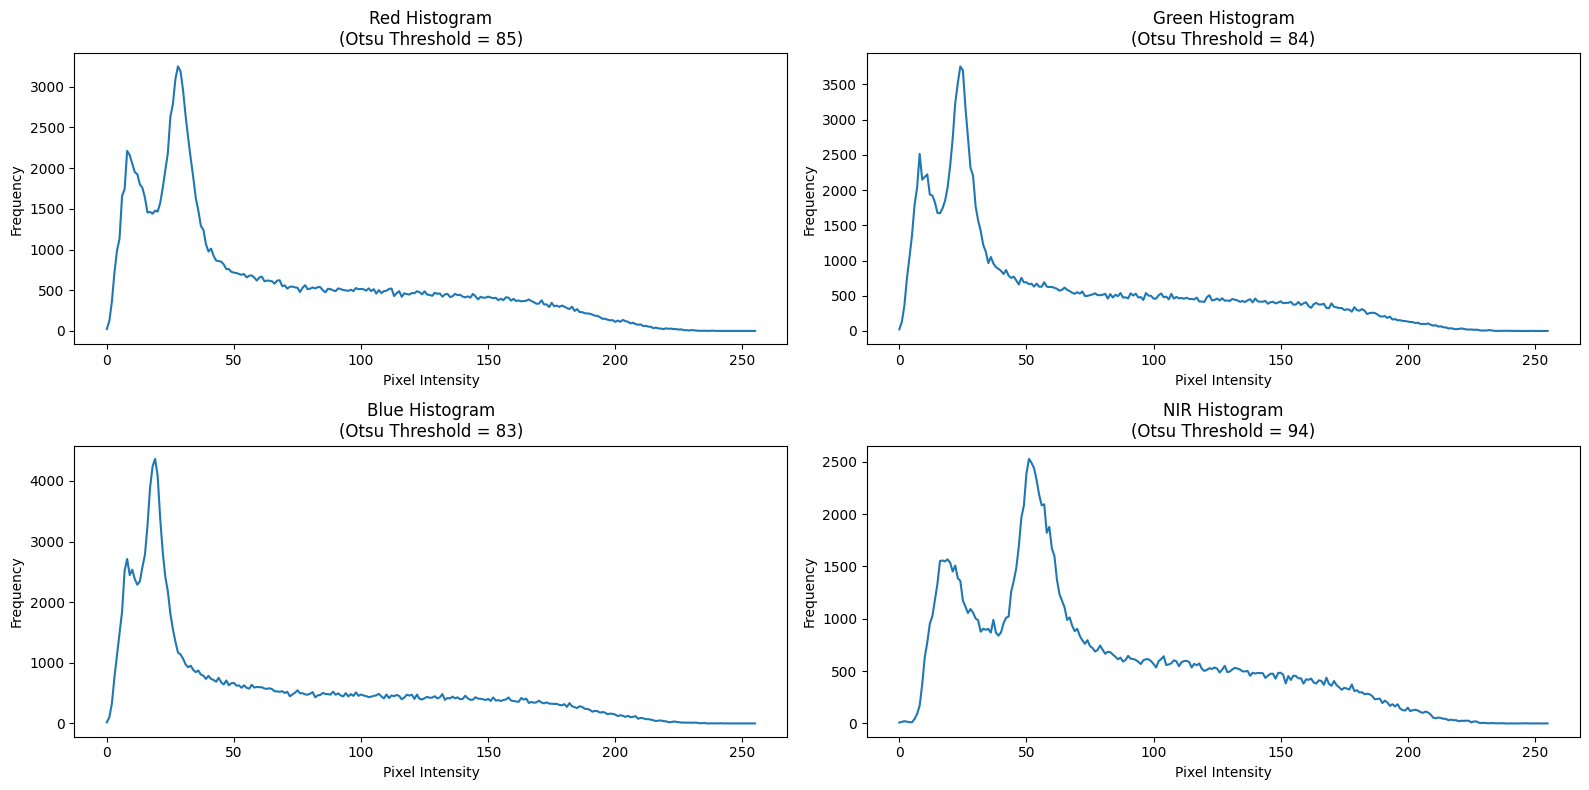

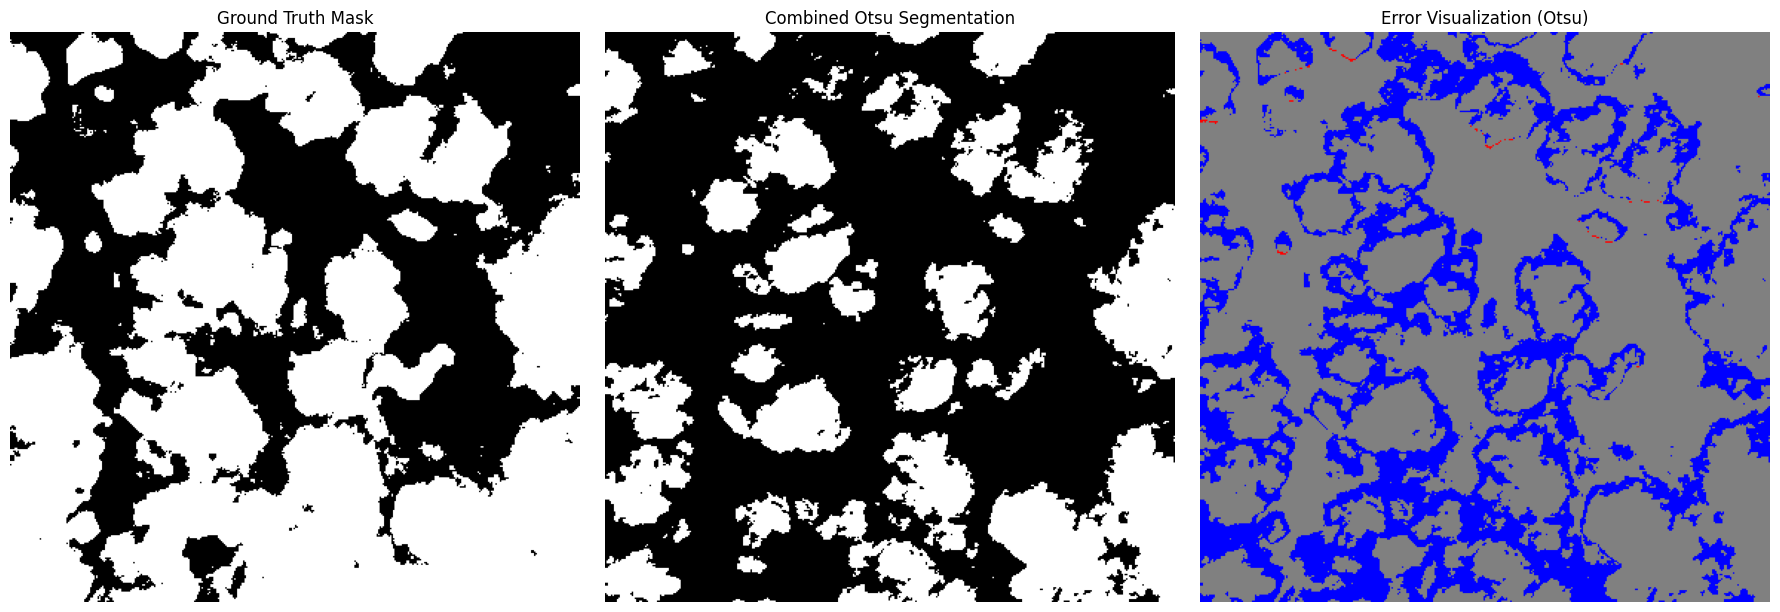

In [7]:
# Compute and plot Otsu histograms and obtain binary masks.
otsu_masks, otsu_thresholds = compute_otsu_masks(normalized)

# Combine Otsu masks via majority vote.
segmentation_otsu = combine_otsu_masks(otsu_masks, vote_threshold=3)

# Compute error visualization for Otsu.
error_vis_otsu = compute_error_visualization(segmentation_otsu, ground_truth)

# Display Otsu segmentation results.
plot_segmentation_results(ground_truth, segmentation_otsu, error_vis_otsu,
                          ["Ground Truth Mask", "Combined Otsu Segmentation", "Error Visualization (Otsu)"])


# Supervised Methods

In [8]:
def build_training_dataset(red_files, sample_size=250):
    """Sample training images and build feature and label arrays."""
    if len(red_files) > sample_size:
        sampled_files = random.sample(red_files, sample_size)
    else:
        sampled_files = red_files

    X_list, y_list = [], []
    for red_file in sampled_files:
        norm = load_normalized_bands(red_file)
        features = np.stack([norm['red'], norm['green'], norm['blue'], norm['nir']], axis=-1)
        H, W, _ = features.shape
        features_flat = features.reshape(-1, 4).astype(np.float32) / 255.0

        gt_file = get_ground_truth(red_file)
        ground_truth_img = open_tif(gt_file).numpy().astype(np.uint8)
        ground_truth_bin = (ground_truth_img > 127).astype(np.float32).flatten()

        X_list.append(features_flat)
        y_list.append(ground_truth_bin)

    X_full = np.concatenate(X_list, axis=0)
    y_full = np.concatenate(y_list, axis=0)
    return X_full, y_full

# First, sample a set of training images.
training_sample_size = 500
training_files = random.sample(red_files, training_sample_size)
X_full, y_full = build_training_dataset(training_files, sample_size=training_sample_size)

# Define the test set by excluding the training images.
test_files = [f for f in red_files if f not in training_files]
test_sample_size = min(1000, len(test_files))
sampled_test_files = random.sample(test_files, test_sample_size)

In [9]:
# Prepare test image features.
norm_test = load_normalized_bands(selected_red)
features_test = np.stack([norm_test['red'], norm_test['green'],
                            norm_test['blue'], norm_test['nir']], axis=-1)
H, W, _ = features_test.shape
X_test = features_test.reshape(-1, 4).astype(np.float32) / 255.0

## GNB

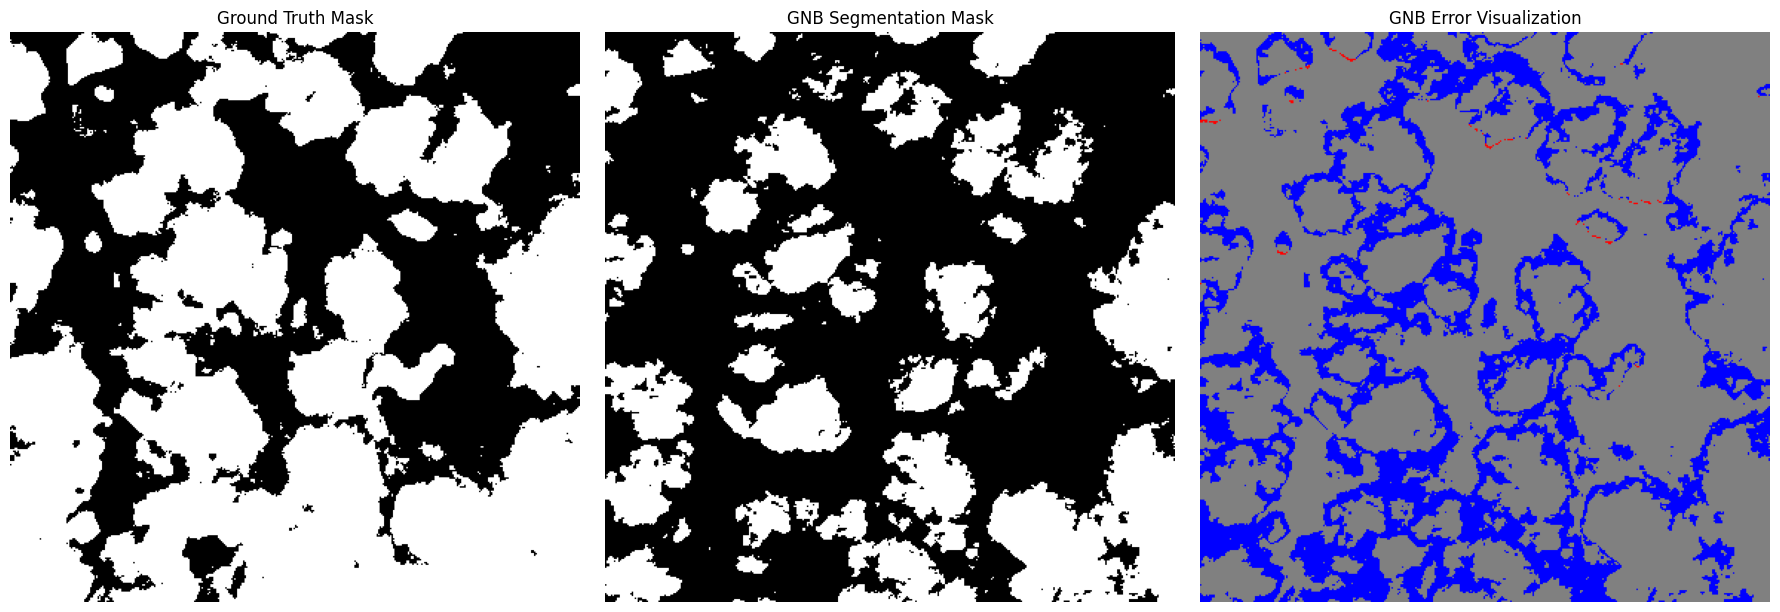

In [10]:
def train_gnb(X, y):
    """Compute per-feature means, variances, and class priors for GNB."""
    X0 = X[y == 0]
    X1 = X[y == 1]
    mean0 = X0.mean(axis=0)
    var0 = X0.var(axis=0) + 1e-6
    mean1 = X1.mean(axis=0)
    var1 = X1.var(axis=0) + 1e-6
    prior0 = X0.shape[0] / X.shape[0]
    prior1 = X1.shape[0] / X.shape[0]
    return (mean0, var0, mean1, var1, prior0, prior1)

def log_gaussian(x, mean, var):
    """Helper to compute log Gaussian likelihood."""
    return -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x - mean) ** 2 / var)

def predict_gnb(X_test, stats, shape):
    """Predict segmentation using Gaussian Naive Bayes."""
    mean0, var0, mean1, var1, prior0, prior1 = stats
    log_prob0 = np.log(prior0) + np.sum(log_gaussian(X_test, mean0, var0), axis=1)
    log_prob1 = np.log(prior1) + np.sum(log_gaussian(X_test, mean1, var1), axis=1)
    y_pred = (log_prob1 > log_prob0).astype(np.uint8)
    segmentation = y_pred.reshape(shape) * 255
    return segmentation

# Train GNB.
gnb_stats = train_gnb(X_full, y_full)
segmentation_gnb = predict_gnb(X_test, gnb_stats, (H, W))
error_vis_gnb = compute_error_visualization(segmentation_gnb, ground_truth)
plot_segmentation_results(ground_truth, segmentation_gnb, error_vis_gnb,
                          ["Ground Truth Mask", "GNB Segmentation Mask", "GNB Error Visualization"])


## Histogram-based Supervised Method

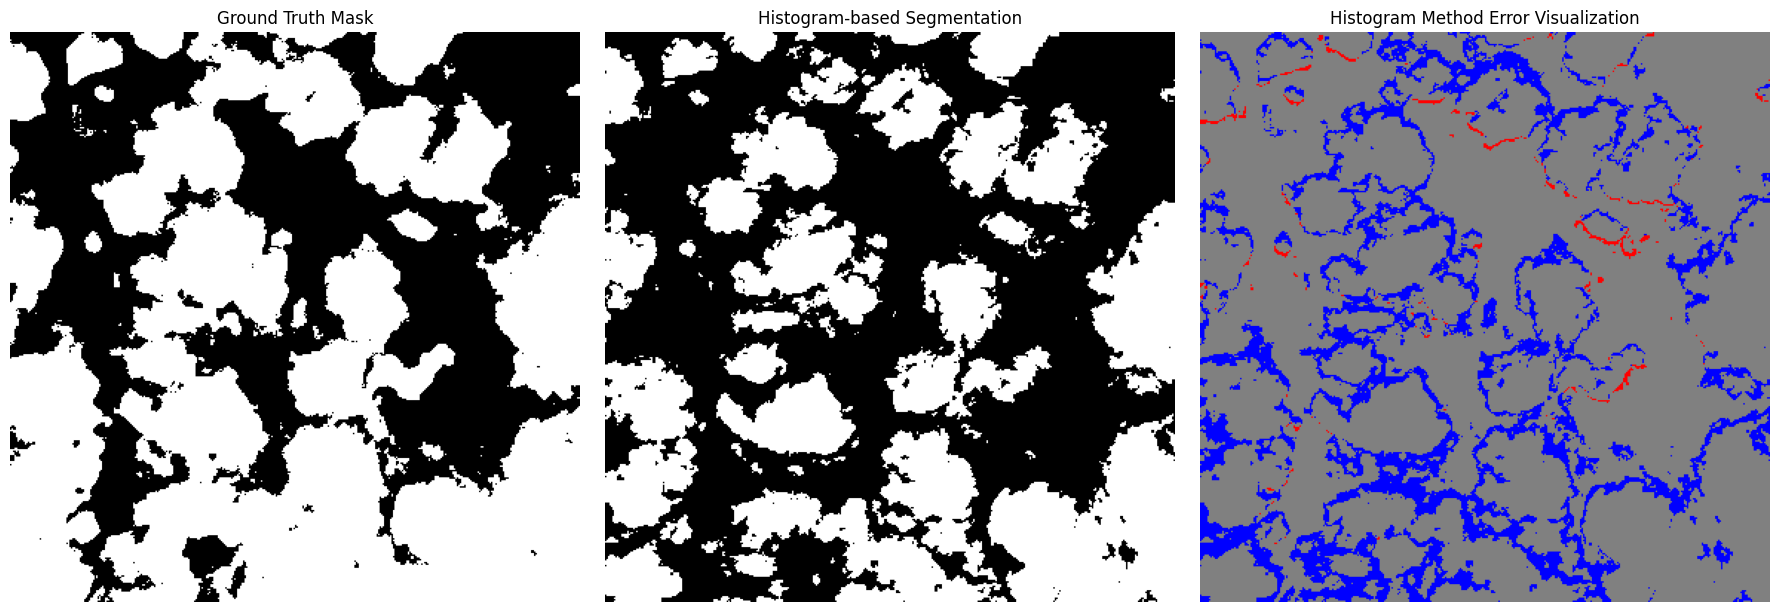

In [11]:
def train_histogram_classifier(X, y, nbins=32):
    """Train a histogram-based classifier."""
    bins = np.linspace(0, 1, nbins + 1)
    histograms0 = np.zeros((4, nbins))
    histograms1 = np.zeros((4, nbins))
    for i in range(4):
        feature_vals0 = X[y == 0][:, i]
        feature_vals1 = X[y == 1][:, i]
        counts0, _ = np.histogram(feature_vals0, bins=bins)
        counts1, _ = np.histogram(feature_vals1, bins=bins)
        histograms0[i, :] = counts0
        histograms1[i, :] = counts1
    # Laplace smoothing.
    histograms0 += 1
    histograms1 += 1
    prob_hist0 = histograms0 / histograms0.sum(axis=1, keepdims=True)
    prob_hist1 = histograms1 / histograms1.sum(axis=1, keepdims=True)
    return bins, prob_hist0, prob_hist1

def predict_histogram(X_test, bins, prob_hist0, prob_hist1, prior0, prior1, shape):
    """Predict segmentation using the histogram-based classifier."""
    nbins = len(bins) - 1
    bin_indices = np.digitize(X_test, bins) - 1
    bin_indices = np.clip(bin_indices, 0, nbins - 1)
    log_prob0 = np.zeros(X_test.shape[0])
    log_prob1 = np.zeros(X_test.shape[0])
    for i in range(4):
        log_prob0 += np.log(prob_hist0[i, bin_indices[:, i]])
        log_prob1 += np.log(prob_hist1[i, bin_indices[:, i]])
    log_prob0 += np.log(prior0)
    log_prob1 += np.log(prior1)
    y_pred = (log_prob1 > log_prob0).astype(np.uint8)
    segmentation = y_pred.reshape(shape) * 255
    return segmentation

# Train histogram classifier.
nbins = 32
bins, prob_hist0, prob_hist1 = train_histogram_classifier(X_full, y_full, nbins)
# Get class priors.
prior0 = np.sum(y_full == 0) / y_full.shape[0]
prior1 = np.sum(y_full == 1) / y_full.shape[0]
segmentation_hist = predict_histogram(X_test, bins, prob_hist0, prob_hist1, prior0, prior1, (H, W))
error_vis_hist = compute_error_visualization(segmentation_hist, ground_truth)
plot_segmentation_results(ground_truth, segmentation_hist, error_vis_hist,
                          ["Ground Truth Mask", "Histogram-based Segmentation", "Histogram Method Error Visualization"])


## Decision Tree

Decision Tree Classifier trained.


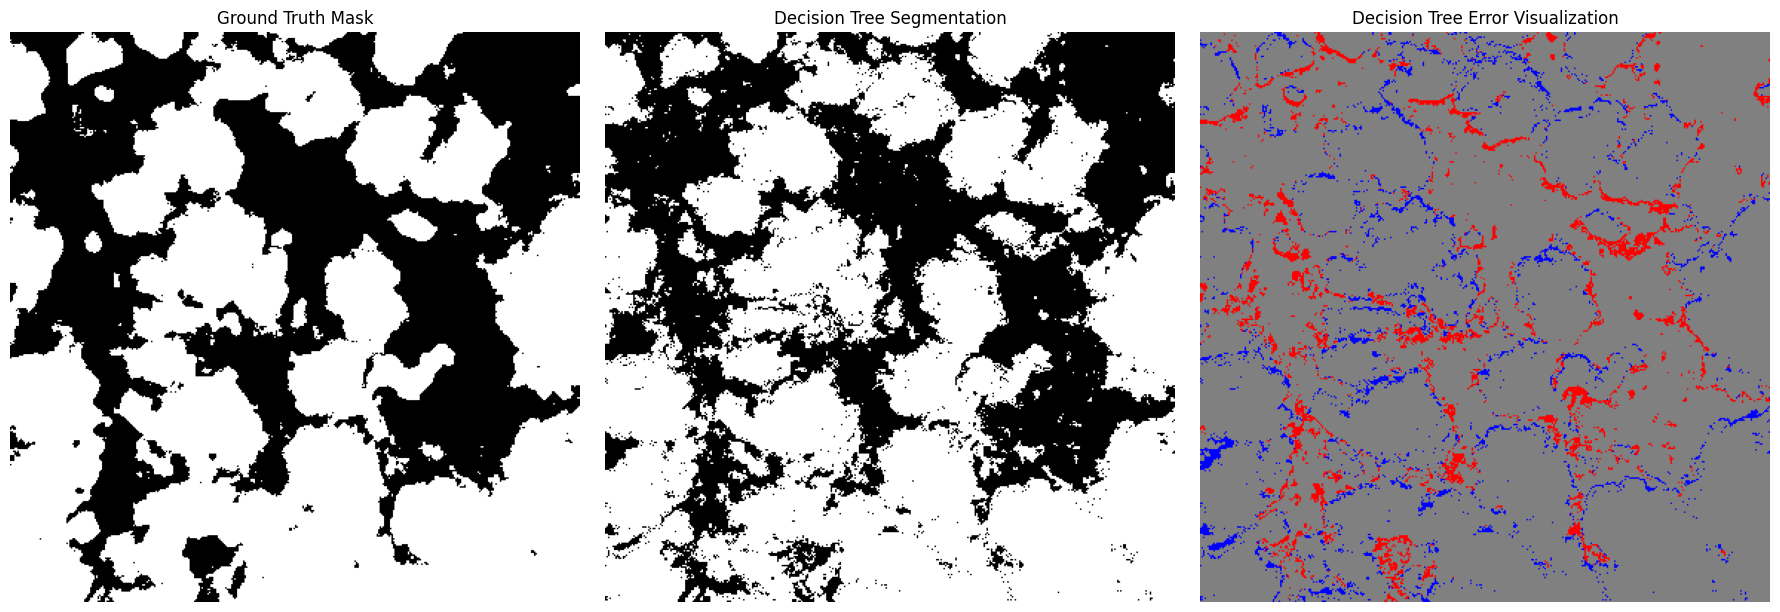

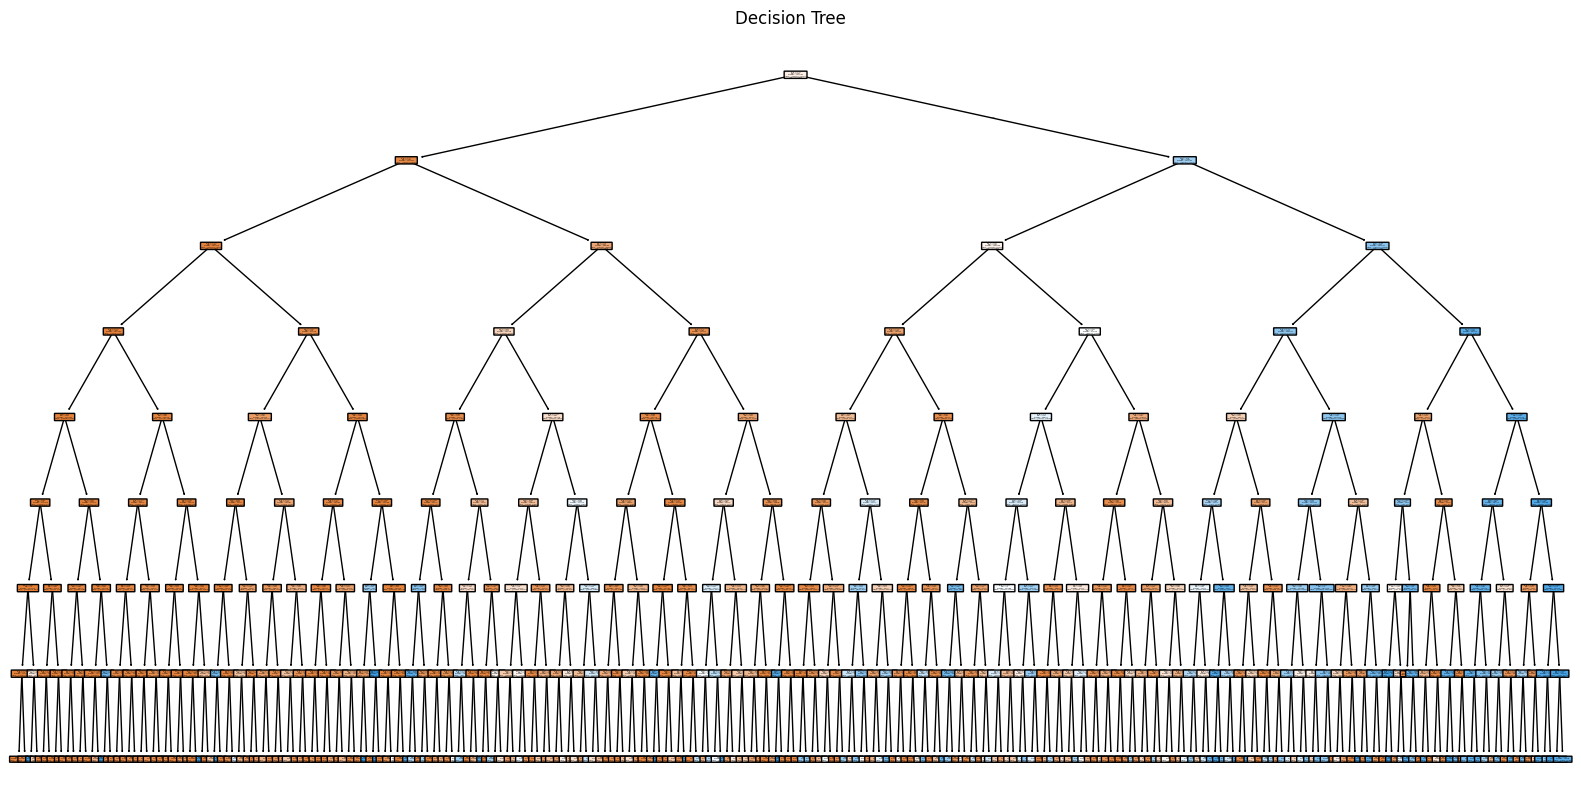

In [12]:
def train_decision_tree(X, y, max_depth=8):
    """Train a Decision Tree Classifier."""
    from sklearn.tree import DecisionTreeClassifier
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X, y)
    return clf

def predict_decision_tree(clf, X_test, shape):
    """Predict segmentation using the trained decision tree."""
    y_pred = clf.predict(X_test)
    segmentation = (y_pred.reshape(shape) > 0.5).astype(np.uint8) * 255
    return segmentation

# Train and predict with Decision Tree.
clf_dt = train_decision_tree(X_full, y_full)
print("Decision Tree Classifier trained.")
segmentation_dt = predict_decision_tree(clf_dt, X_test, (H, W))
error_vis_dt = compute_error_visualization(segmentation_dt, ground_truth)
plot_segmentation_results(ground_truth, segmentation_dt, error_vis_dt,
                          ["Ground Truth Mask", "Decision Tree Segmentation", "Decision Tree Error Visualization"])

# Visualize the decision tree.
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(clf_dt, feature_names=['Red', 'Green', 'Blue', 'NIR'],
          class_names=['Non-Cloud', 'Cloud'], filled=True, rounded=True)
plt.title("Decision Tree")
plt.show()

# Metrics

In [ ]:
def compute_metrics(segmentation, ground_truth):
    seg_bin = (segmentation == 255).astype(np.uint8)
    gt_bin = (ground_truth == 255).astype(np.uint8)
    tp = np.sum((seg_bin == 1) & (gt_bin == 1))
    fp = np.sum((seg_bin == 1) & (gt_bin == 0))
    fn = np.sum((seg_bin == 0) & (gt_bin == 1))
    tn = np.sum((seg_bin == 0) & (gt_bin == 0))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    jaccard   = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    accuracy  = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
    return precision, recall, f1, jaccard, accuracy

In [ ]:
# Evaluate metrics over a sample of images.

metrics_sum = {
    "GNB": np.zeros(5),
    "Histogram": np.zeros(5),
    "Otsu": np.zeros(5),
    "DT": np.zeros(5),
    "KMeans": np.zeros(5),
    "SLIC": np.zeros(5),
    "Ensemble": np.zeros(5)
}
count = 0

for red_file in sampled_test_files:
    norm = load_normalized_bands(red_file)
    features = np.stack([norm['red'], norm['green'], norm['blue'], norm['nir']], axis=-1)
    H_img, W_img, _ = features.shape
    X_img = features.reshape(-1, 4).astype(np.float32) / 255.0
    gt_file = get_ground_truth(red_file)
    gt_img = open_tif(gt_file).numpy().astype(np.uint8)

    # Predictions from individual methods.
    seg_gnb    = predict_gnb(X_img, gnb_stats, (H_img, W_img))
    seg_hist   = predict_histogram(X_img, bins, prob_hist0, prob_hist1, prior0, prior1, (H_img, W_img))
    otsu_masks_img, _ = compute_otsu_masks(norm, display_hist=False)
    seg_otsu   = combine_otsu_masks(otsu_masks_img, vote_threshold=3)
    seg_dt     = predict_decision_tree(clf_dt, X_img, (H_img, W_img))
    seg_kmeans = predict_kmeans(X_img, (H_img, W_img), n_clusters=2, random_state=42)
    seg_slic   = predict_slic(norm, n_segments=250, compactness=15, sigma=1, invert_output=False)

    # Ensemble: combine all six methods. For example, require at least 2 out of 6 to vote cloud.
    seg_ensemble = ensemble_segmentation_all([seg_gnb, seg_hist, seg_otsu, seg_dt, seg_kmeans, seg_slic], threshold=2)

    # Accumulate metrics for each method.
    metrics_sum["GNB"]      += np.array(compute_metrics(seg_gnb, gt_img))
    metrics_sum["Histogram"]+= np.array(compute_metrics(seg_hist, gt_img))
    metrics_sum["Otsu"]     += np.array(compute_metrics(seg_otsu, gt_img))
    metrics_sum["DT"]       += np.array(compute_metrics(seg_dt, gt_img))
    metrics_sum["KMeans"]   += np.array(compute_metrics(seg_kmeans, gt_img))
    metrics_sum["SLIC"]     += np.array(compute_metrics(seg_slic, gt_img))
    metrics_sum["Ensemble"] += np.array(compute_metrics(seg_ensemble, gt_img))

    count += 1

avg_metrics = {method: metrics_sum[method] / count for method in metrics_sum}

print("Average Metrics over {} test images:".format(count))
print("GNB:              Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Jaccard: {:.4f}, Accuracy: {:.4f}"
      .format(*avg_metrics["GNB"]))
print("Histogram-based:  Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Jaccard: {:.4f}, Accuracy: {:.4f}"
      .format(*avg_metrics["Histogram"]))
print("Otsu's Method:    Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Jaccard: {:.4f}, Accuracy: {:.4f}"
      .format(*avg_metrics["Otsu"]))
print("Decision Tree:    Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Jaccard: {:.4f}, Accuracy: {:.4f}"
      .format(*avg_metrics["DT"]))
print("K-Means:          Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Jaccard: {:.4f}, Accuracy: {:.4f}"
      .format(*avg_metrics["KMeans"]))
print("SLIC:             Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Jaccard: {:.4f}, Accuracy: {:.4f}"
      .format(*avg_metrics["SLIC"]))
print("Ensemble:         Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Jaccard: {:.4f}, Accuracy: {:.4f}"
      .format(*avg_metrics["Ensemble"]))

# Limits

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def overlay_mask(rgb, mask, overlay_color, alpha=0.4):
    overlay = np.zeros_like(rgb, dtype=np.uint8)
    overlay[mask == 255] = overlay_color
    blended = cv2.addWeighted(rgb, 1 - alpha, overlay, alpha, 0)
    return blended

def create_differential_overlay(rgb, pred, gt, alpha=0.4):
    overlay = np.zeros_like(rgb, dtype=np.uint8)
    # True Positives: predicted 255 & GT 255 -> Yellow (255, 255, 0)
    TP_mask = (pred == 255) & (gt == 255)
    overlay[TP_mask] = (255, 255, 0)
    # False Positives: predicted 255 & GT 0 -> Red (255, 0, 0)
    FP_mask = (pred == 255) & (gt == 0)
    overlay[FP_mask] = (255, 0, 0)
    # False Negatives: predicted 0 & GT 255 -> Blue (0, 0, 255)
    FN_mask = (pred == 0) & (gt == 255)
    overlay[FN_mask] = (0, 0, 255)
    blended = cv2.addWeighted(rgb, 1 - alpha, overlay, alpha, 0)
    return blended

def display_segmentation_by_index(index, method):
    # Get the file path from global test_files.
    red_file = test_files[index]
    print(f"Image index: {index}, File: {red_file}")

    # Load normalized bands and build composite RGB image.
    normalized = load_normalized_bands(red_file)
    rgb = np.stack([normalized['red'], normalized['green'], normalized['blue']], axis=-1)

    # Load ground truth.
    gt_file = get_ground_truth(red_file)
    gt = open_tif(gt_file).numpy().astype(np.uint8)

    # Build feature array for pixel-based methods.
    features = np.stack([normalized['red'], normalized['green'],
                         normalized['blue'], normalized['nir']], axis=-1)
    H, W, _ = features.shape
    X = features.reshape(-1, 4).astype(np.float32) / 255.0

    # Compute prediction based on the chosen method.
    if method == "GNB":
        pred = predict_gnb(X, gnb_stats, (H, W))
    elif method == "Histogram":
        pred = predict_histogram(X, bins, prob_hist0, prob_hist1, prior0, prior1, (H, W))
    elif method == "Otsu":
        otsu_masks, _ = compute_otsu_masks(normalized, display_hist=False)
        pred = combine_otsu_masks(otsu_masks, vote_threshold=3)
    elif method == "DT":
        pred = predict_decision_tree(clf_dt, X, (H, W))
    elif method == "KMeans":
        pred = predict_kmeans(X, (H, W), n_clusters=2, random_state=42)
    elif method == "SLIC":
        pred = predict_slic(normalized, n_segments=250, compactness=10, sigma=1, invert_output=False)
    elif method == "Ensemble":
        seg_gnb = predict_gnb(X, gnb_stats, (H, W))
        seg_hist = predict_histogram(X, bins, prob_hist0, prob_hist1, prior0, prior1, (H, W))
        otsu_masks, _ = compute_otsu_masks(normalized, display_hist=False)
        seg_otsu = combine_otsu_masks(otsu_masks, vote_threshold=3)
        seg_dt = predict_decision_tree(clf_dt, X, (H, W))
        seg_kmeans = predict_kmeans(X, (H, W), n_clusters=2, random_state=42)
        seg_slic = predict_slic(normalized, n_segments=250, compactness=10, sigma=1, invert_output=False)
        pred = ensemble_segmentation_all(
            [seg_gnb, seg_hist, seg_otsu, seg_dt, seg_kmeans, seg_slic],
            threshold=2
        )

    # Create overlays.
    rgb_gt_overlay = overlay_mask(rgb, gt, overlay_color=(255, 255, 0), alpha=0.4)
    rgb_diff_overlay = create_differential_overlay(rgb, pred, gt, alpha=0.4)

    # Display the results.
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(rgb)
    axs[0].set_title("Original RGB")
    axs[0].axis("off")

    axs[1].imshow(rgb_gt_overlay)
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    axs[2].imshow(rgb_diff_overlay)
    axs[2].set_title(f"({method}) Predictions Error Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
display_segmentation_by_index(235, "SLIC")

In [ ]:
display_segmentation_by_index(235, "DT")

In [ ]:
display_segmentation_by_index(235, "Otsu")

In [ ]:
display_segmentation_by_index(235, "Ensemble")

In [ ]:
display_segmentation_by_index(235, "KMeans")

In [ ]:
display_segmentation_by_index(2, "DT")

In [ ]:
display_segmentation_by_index(2, "Otsu")

In [ ]:
display_segmentation_by_index(2, "Ensemble")

In [ ]:
display_segmentation_by_index(3, "DT")

In [ ]:
def denoise_mask(mask, median_kernel_size=12, morph_kernel_size=3):
    # Apply a median filter.
    denoised = cv2.medianBlur(mask, median_kernel_size)

    # Create a small structuring element for morphological opening.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_kernel_size, morph_kernel_size))
    denoised = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)

    return denoised

In [ ]:
# Load normalized bands for the selected test image.
normalized = load_normalized_bands(selected_red)

# For consistency, extract the multi-spectral image. This also helps us retrieve the image dimensions.
band_files = get_filenames(selected_red)
ms_image = open_ms_tif(band_files)
H, W = ms_image.shape[1], ms_image.shape[2]  # Shape: [4, H, W]

# Build the feature array using the normalized bands (red, green, blue, NIR).
features = np.stack([normalized['red'], normalized['green'], normalized['blue'], normalized['nir']], axis=-1)
X_test = features.reshape(-1, 4).astype(np.float32) / 255.0

# Use the decision tree to predict the segmentation.
# predict_decision_tree should be defined as a function that takes the classifier, X_test, and the image shape.
seg_dt = predict_decision_tree(clf_dt, X_test, (H, W))
seg_dt2 = denoise_mask(seg_dt, median_kernel_size=5, morph_kernel_size=3)

# Optionally, load the ground truth mask for comparison.
gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)

# Display the decision tree segmentation result using your plotting function.

plot_segmentation_results(ground_truth, seg_dt2, compute_error_visualization(seg_dt2, ground_truth),
                          ["Ground Truth Mask", "Decision Tree With Smoothing Segmentation Mask", "Error Visualization"])

# Unused

## Ensembling

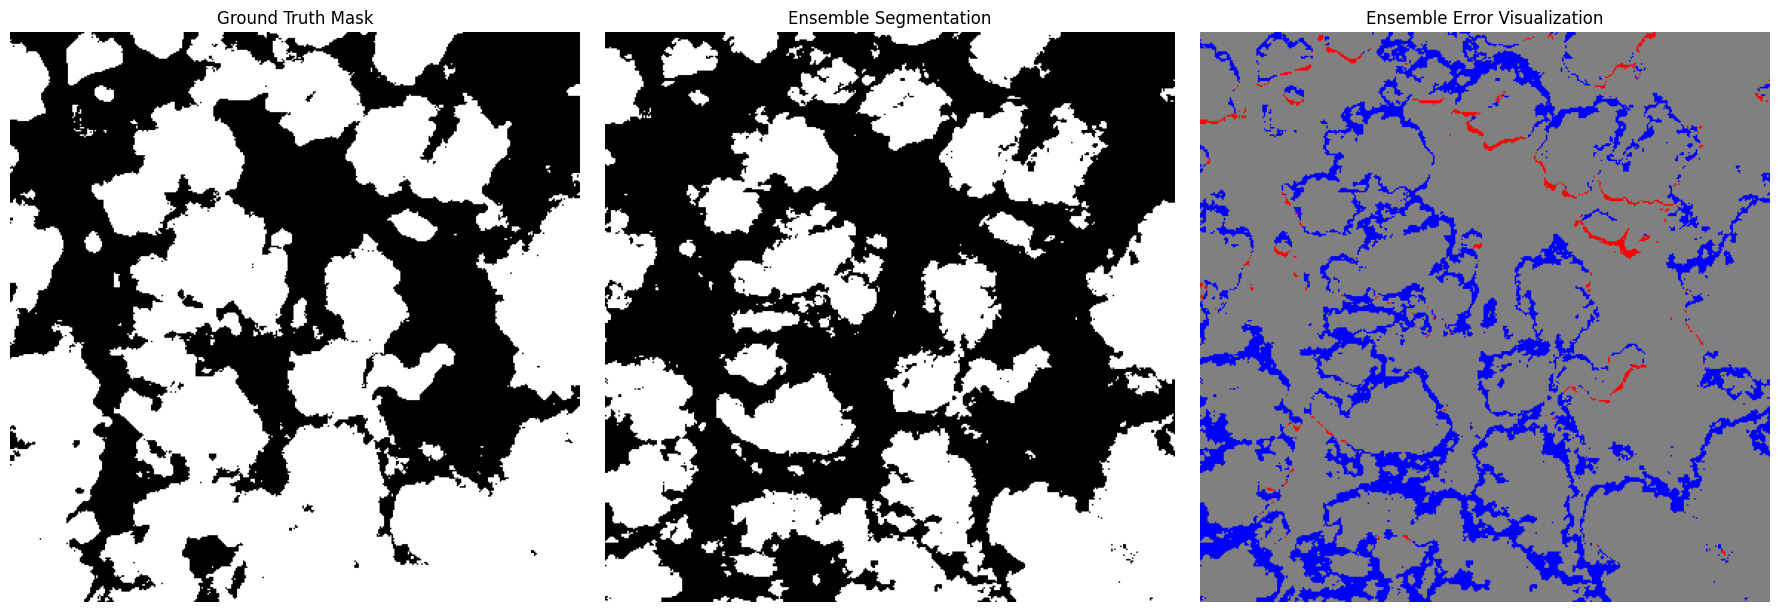

In [20]:
def ensemble_segmentation_all(segmentations, threshold):
    """
    Combine segmentation masks from multiple methods by majority vote.

    Args:
        segmentations (list): List of binary segmentation masks (0 or 255).
        threshold (int): Minimum number of methods that must vote cloud (255)
                         for the ensemble to label the pixel as cloud.

    Returns:
        ensemble_mask (np.ndarray): Combined binary segmentation mask.
    """
    votes = [(seg == 255).astype(np.uint8) for seg in segmentations]
    vote_sum = sum(votes)
    ensemble_mask = np.where(vote_sum >= threshold, 255, 0).astype(np.uint8)
    return ensemble_mask

# Compute predictions from individual methods.
norm_test = load_normalized_bands(selected_red)
features_test = np.stack([norm_test['red'], norm_test['green'], norm_test['blue'], norm_test['nir']], axis=-1)
H, W, _ = features_test.shape
X_test = features_test.reshape(-1, 4).astype(np.float32) / 255.0

seg_gnb_test    = predict_gnb(X_test, gnb_stats, (H, W))
seg_hist_test   = predict_histogram(X_test, bins, prob_hist0, prob_hist1, prior0, prior1, (H, W))
otsu_masks_test, _ = compute_otsu_masks(norm_test, display_hist=False)
seg_otsu_test   = combine_otsu_masks(otsu_masks_test, vote_threshold=3)
seg_dt_test     = predict_decision_tree(clf_dt, X_test, (H, W))
seg_kmeans_test = predict_kmeans(X_test, (H, W), n_clusters=2, random_state=42)
seg_slic_test   = predict_slic(norm_test, n_segments=250, compactness=10, sigma=1, invert_output=False)

# Ensemble segmentation using all six methods.
# Here we require at least 4 methods (out of 6) to vote for cloud (255) to classify a pixel as cloud.
seg_ensemble_test = ensemble_segmentation_all(
    [seg_gnb_test, seg_hist_test, seg_otsu_test, seg_dt_test, seg_kmeans_test, seg_slic_test],
    threshold=2
)

# Load the ground truth mask.
gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)

# Compute error visualization for the ensemble result.
error_vis_ensemble_test = compute_error_visualization(seg_ensemble_test, ground_truth)

# Display the ensemble segmentation result.
plot_segmentation_results(ground_truth, seg_ensemble_test, error_vis_ensemble_test,
                          ["Ground Truth Mask", "Ensemble Segmentation", "Ensemble Error Visualization"])

## KMeans

In [14]:
from sklearn.cluster import KMeans

In [15]:
def predict_kmeans(X_test, shape, n_clusters=2, random_state=42):
    """
    Predict segmentation mask using K-means clustering.

    Args:
        X_test (np.ndarray): Feature matrix for the test image with shape (num_pixels, num_features).
        shape (tuple): The (height, width) dimensions of the test image.
        n_clusters (int): Number of clusters to use (default is 2 for cloud vs. non-cloud).
        random_state (int): Random state for reproducibility.

    Returns:
        segmentation (np.ndarray): Binary segmentation mask with values 0 (non-cloud) or 255 (cloud).
    """
    # Fit K-means to the pixel features.
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(X_test)

    # Determine which cluster corresponds to clouds.
    # Here, we assume that cloud pixels have a higher average intensity.
    # Compute the average intensity (sum of all features) per cluster.
    cluster_intensities = [np.mean(np.sum(X_test[labels == i], axis=1)) for i in range(n_clusters)]
    cloud_cluster = np.argmax(cluster_intensities)

    # Create binary segmentation mask.
    segmentation = (labels == cloud_cluster).astype(np.uint8) * 255
    segmentation = segmentation.reshape(shape)
    return segmentation

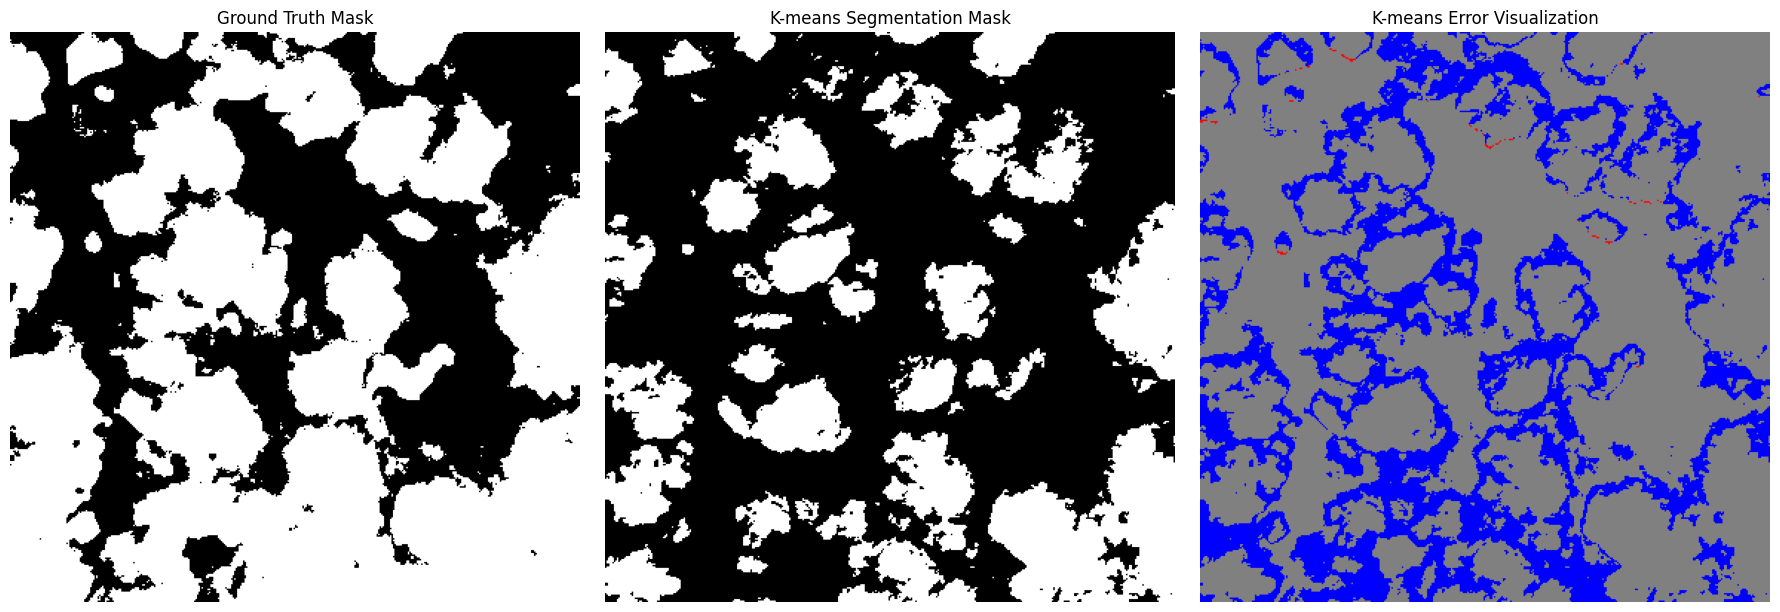

In [16]:
# Load normalized bands for a selected test image.
norm_test = load_normalized_bands(selected_red)

# Stack the bands into a feature array (H x W x 4) and flatten to (num_pixels, 4).
features_test = np.stack([norm_test['red'], norm_test['green'], norm_test['blue'], norm_test['nir']], axis=-1)
H, W, _ = features_test.shape
X_test = features_test.reshape(-1, 4).astype(np.float32) / 255.0  # Scale features to [0,1]

# Predict the segmentation mask using K-means.
seg_kmeans = predict_kmeans(X_test, (H, W), n_clusters=2, random_state=42)

# Load the ground truth mask.
gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)

# Compute error visualization and display the results.
error_vis_kmeans = compute_error_visualization(seg_kmeans, ground_truth)
plot_segmentation_results(ground_truth, seg_kmeans, error_vis_kmeans,
                          ["Ground Truth Mask", "K-means Segmentation Mask", "K-means Error Visualization"])

## SLIC

In [17]:
from skimage.segmentation import slic

In [18]:
def predict_slic(normalized, n_segments=200, compactness=5, sigma=0.01, invert_output=False):
    """
    Perform segmentation using SLIC superpixels and classify each superpixel as cloud or non-cloud.

    Args:
        normalized (dict): Dictionary containing normalized bands with keys 'red', 'green', 'blue'.
                           (The NIR band is ignored in this method.)
        n_segments (int): Approximate number of superpixels.
        compactness (float): Balances color proximity and space proximity for SLIC.
        sigma (float): Width of Gaussian smoothing kernel for pre-processing.
        invert_output (bool): If True, inverts the final binary mask.

    Returns:
        segmentation (np.ndarray): Binary segmentation mask (0 for non-cloud, 255 for cloud).
    """
    # Create composite RGB image from normalized bands.
    rgb = np.stack([normalized['red'], normalized['green'], normalized['blue']], axis=-1)
    # Convert to grayscale using OpenCV.
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    # Compute superpixels using SLIC.
    segments = slic(rgb, n_segments=n_segments, compactness=compactness, sigma=sigma, start_label=0)

    # Compute a global Otsu threshold on the grayscale image.
    # cv2.threshold returns (retval, thresholded_image); we want the threshold value.
    global_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]

    # For each superpixel, compute the mean intensity.
    seg_ids = np.unique(segments)
    superpixel_labels = np.zeros(len(seg_ids), dtype=np.uint8)
    for idx, seg_id in enumerate(seg_ids):
        mean_intensity = np.mean(gray[segments == seg_id])
        # Label as cloud (255) if the superpixel's mean is greater than the global threshold.
        superpixel_labels[idx] = 255 if mean_intensity > global_thresh else 0

    # Build the binary segmentation mask.
    segmentation = np.zeros_like(gray, dtype=np.uint8)
    for idx, seg_id in enumerate(seg_ids):
        segmentation[segments == seg_id] = superpixel_labels[idx]

    if invert_output:
        segmentation = 255 - segmentation

    return segmentation

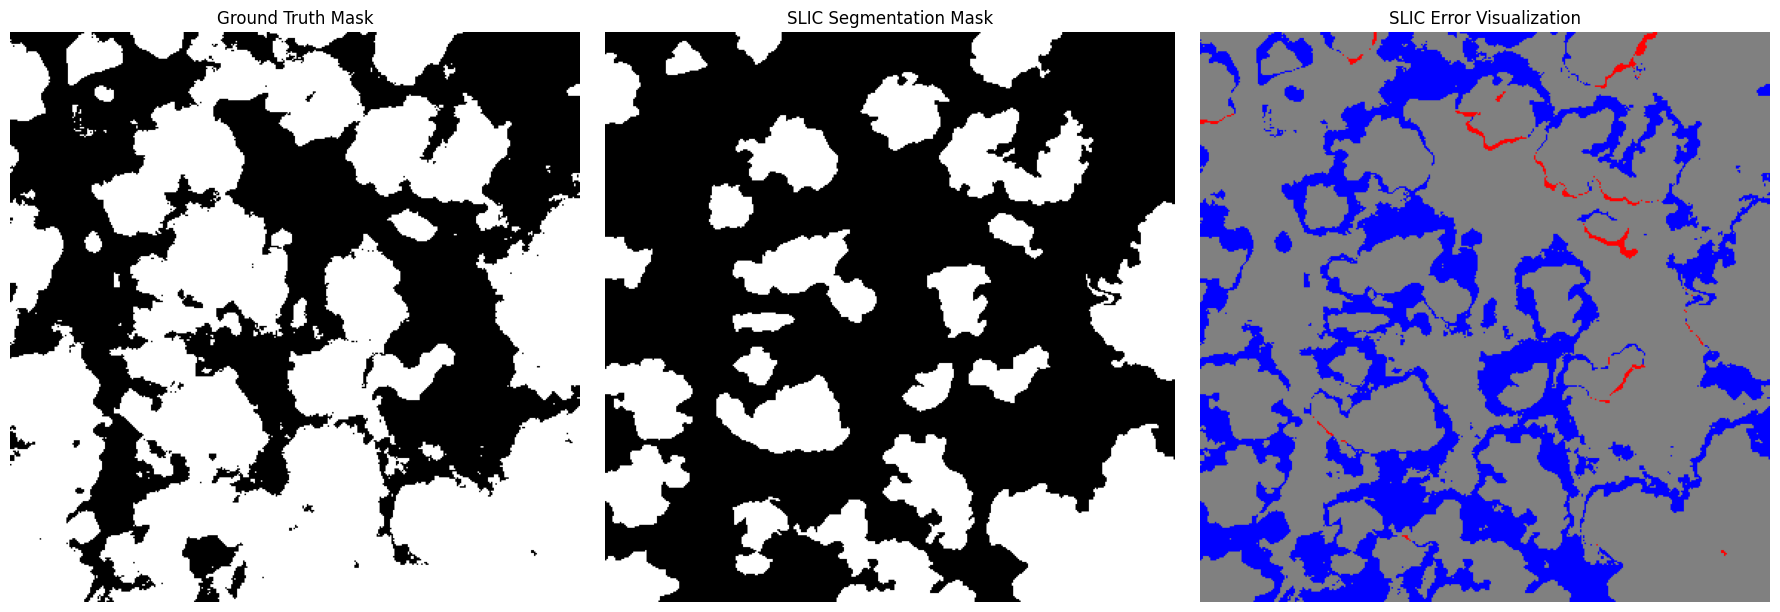

In [19]:
# Load normalized bands for a selected test image.
norm_test = load_normalized_bands(selected_red)

# Predict the segmentation mask using SLIC.
seg_slic = predict_slic(norm_test, n_segments=250, compactness=10, sigma=1, invert_output=False)

# Load the ground truth mask.
gt_file = get_ground_truth(selected_red)
ground_truth = open_tif(gt_file).numpy().astype(np.uint8)

# Compute error visualization and display the results.
error_vis_slic = compute_error_visualization(seg_slic, ground_truth)
plot_segmentation_results(ground_truth, seg_slic, error_vis_slic,
                          ["Ground Truth Mask", "SLIC Segmentation Mask", "SLIC Error Visualization"])